# Global brassicaceae checklist, Brassibase and IPNI comparisons

I put all the data into dataframes and the dataframes into a diccionary, and created a list with the diccionary keys. 

In [47]:
import re
import glob
import numpy as np
import pandas as pd
from lxml import etree
import csv

parser = etree.XMLParser(remove_blank_text=True)
our_accepted_list = pd.read_csv('/home/lujantorob/global_brassicaceae_checklist_v2/data/interim/species_checklist_v2.6.1_accepted_ipni_scored.csv').fillna("")
bb_accepted_list = pd.read_csv('/home/lujantorob/global_brassicaceae_checklist_v2/data/interim/brassicaceae_species_bb1-3_accepted_ipni_scored.csv').fillna("")
our_synonym_list = pd.read_csv('/home/lujantorob/global_brassicaceae_checklist_v2/data/interim/species_checklist_v2.6.1_synonym_ipni_scored.csv').fillna("")
bb_synonym_list = pd.read_csv('/home/lujantorob/global_brassicaceae_checklist_v2/data/interim/brassicaceae_species_bb1-3_synonym_ipni_scored.csv').fillna("")
ipni_col = ["id","full name","name author","scientific name","family","infrafamily","genus","infragenus","species",
            "infraspecies","hybrid","hybrid genus","rank","published", "name status"]

ipni_list = pd.read_csv('/home/lujantorob/global_brassicaceae_checklist_v2/data/external/ipni_brassicaceae_20201109.csv',
                       usecols=ipni_col).fillna("")

print(len(our_accepted_list))
print(len(our_synonym_list))
print(len(bb_accepted_list))
print(len(bb_synonym_list))
print(len(ipni_list))

all_df = {"our_accepted": our_accepted_list, "our_synonym": our_synonym_list, 
             "bb_accepted": bb_accepted_list, "bb_synonym": bb_synonym_list}
df_keys = ("our_accepted", "our_synonym", "bb_accepted", "bb_synonym")

seen = {}
dupes = []

for x in our_accepted_list.SUBMITTED_NAME:
    if x not in seen:
        seen[x] = 1
    else:
        if seen[x] == 1:
            dupes.append(x)
        seen[x] += 1
print(len(dupes))
print(dupes)

for x in our_synonym_list.SUBMITTED_NAME:
    if x not in seen:
        seen[x] = 1
    else:
        if seen[x] == 1:
            dupes.append(x)
        seen[x] += 1
print(len(dupes))
print(dupes)
#print(all_df[df_keys[0]])

4634
10346
4641
10734
10000
0
[]
4
['Arabis inamoena greene', 'Cardamine bracteata suksd.', 'Lepidium banksii kirk', 'Thlaspi villarsianum jord.']


I then created some summary statistics about the matches, near matches and placed those into a new dataframe called summary_df, also in a diccionary summary_data

In [39]:
score_threshold = 0.8

In [40]:
from __future__ import division

summary_data = {}
for df_name in df_keys:
    #print(df_name)
    df = all_df[df_name]
    exact_df = df[df['MATCH']==True]
    percent = (len(exact_df)/len(df)*100)
    #print("Exact matches: " + str(len(exact_df)) + " representing: " + str(percent))
    
    near_df = df[df['MATCH']==False]
    near_df = near_df[near_df['SCORE']>0.9]
    near_df = near_df[near_df['SCORE2']>=score_threshold] ## NOT SURE WHAT SCORE TO USE
    percent2 = (len(near_df)/len(df)*100)
    #print("Near matches: " + str(len(near_df)) + " representing: " + str(percent2))
    
    if "our" in df_name:
        wo_basionym = df[df['MATCH2']==True]
        summary_data[df_name] = {"exact_match":[len(exact_df)], "near_match":[len(near_df)],
                                  "match_ignore_basio": [len(wo_basionym)],"total":[len(df)] }
    else:
        summary_data[df_name] = {"exact_match":[len(exact_df)], "near_match":[len(near_df)], 
                              "total":[len(df)]}
        
    #print("Total matches: " + str(percent+percent2) )

summary_df = pd.DataFrame (summary_data, columns=df_keys)
    
#print(summary_data)
print(summary_df)



                   our_accepted our_synonym bb_accepted bb_synonym
exact_match              [3288]      [6278]      [2280]     [4858]
match_ignore_basio       [2371]      [5811]         NaN        NaN
near_match                [311]       [566]      [1198]     [2020]
total                    [4634]     [10346]      [4641]    [10734]


                   our_accepted our_synonym bb_accepted bb_synonym
exact_match              [3288]      [6278]      [2280]     [4858]
match_ignore_basio       [2371]      [5811]         NaN        NaN
near_match                 [62]       [176]       [110]      [450]
total                    [4634]     [10346]      [4641]    [10734]

## Francis et al. vs BrassiBase validated against IPNI (simple comparison)



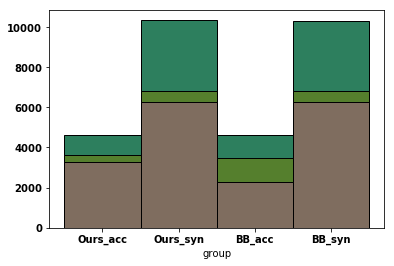

In [41]:
#%matplotlib inline

# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import math
 
# y-axis in bold
rc('font', weight='bold')
 
# Values of each group
exact = [summary_data["our_accepted"]["exact_match"][0],
         summary_data["our_synonym"]["exact_match"][0],
         summary_data["bb_accepted"]["exact_match"][0],
         summary_data["our_synonym"]["exact_match"][0]]
near = [summary_data["our_accepted"]["near_match"][0],
         summary_data["our_synonym"]["near_match"][0],
         summary_data["bb_accepted"]["near_match"][0],
         summary_data["our_synonym"]["near_match"][0]]
nomatch = [(summary_data["our_accepted"]["total"][0]-summary_data["our_accepted"]["exact_match"][0]-summary_data["our_accepted"]["near_match"][0]),
         (summary_data["our_synonym"]["total"][0]-summary_data["our_synonym"]["exact_match"][0]-summary_data["our_synonym"]["near_match"][0]),
         (summary_data["bb_accepted"]["total"][0]-summary_data["bb_accepted"]["exact_match"][0]-summary_data["bb_accepted"]["near_match"][0]),
         (summary_data["our_synonym"]["total"][0]-summary_data["bb_synonym"]["exact_match"][0]-summary_data["bb_synonym"]["near_match"][0])]
 
# Heights of bars1 + bars2
bars = np.add(exact, near).tolist()
 
# The position of the bars on the x-axis
r = [0,1,2,3]
 
# Names of group and bar width
names = ['Ours_acc','Ours_syn','BB_acc','BB_syn']
barWidth = 1
 
# Create brown bars
plt.bar(r, exact, color='#7f6d5f', edgecolor='black', width=barWidth)
# Create green bars (middle), on top of the firs ones
plt.bar(r, near, bottom=exact, color='#557f2d', edgecolor='black', width=barWidth)
# Create green bars (top)
plt.bar(r, nomatch, bottom=bars, color='#2d7f5e', edgecolor='black', width=barWidth)
 
# Custom X axis
plt.xticks(r, names, fontweight='bold')
plt.xlabel("group")
 
# Show graphic
plt.show()


## Francis et al. vs BrassiBase (simple comparison)

Creating a new df called summary_shared 


In [42]:
bb_accepted = bb_accepted_list['SUBMITTED_NAME'].tolist()
bb_synonym = bb_synonym_list['SUBMITTED_NAME'].tolist()

accepted_shared = 0
acc_diff_status_counter = 0
acc_syn_bb = []
for row, name in enumerate(our_accepted_list.SUBMITTED_NAME):  
    if name in bb_accepted:
        accepted_shared += 1
    elif name in bb_synonym:
        acc_diff_status_counter += 1
        acc_syn_bb.append(name)
        
        
#print (acc_syn_bb)
print("Accepted Shared between bb and ours " + str(accepted_shared) + " Different status: " + str(acc_diff_status_counter))
    
synonym_shared = 0
synonym_diff_status_counter = 0
syn_acc_bb = []
for row, name in enumerate(our_synonym_list.SUBMITTED_NAME):  
    if name in bb_synonym:
        synonym_shared += 1
    elif name in bb_accepted:
        synonym_diff_status_counter += 1
        syn_acc_bb.append(name)

summary_shared = {"ours_accepted":[(summary_data["our_accepted"]["total"][0]-accepted_shared)],
                  "bb_accepted":[(summary_data["bb_accepted"]["total"][0]-accepted_shared)], 
                  "shared_accepted":[accepted_shared],
                  "ours_synonym":[(summary_data["our_synonym"]["total"][0]-synonym_shared)], 
                  "bb_synonym": [(summary_data["bb_synonym"]["total"][0]-synonym_shared)],
                  "shared_synonym":[synonym_shared]}    
    
#print(syn_acc_bb) 
print("Synonyms shared between bb and ours " + str(synonym_shared) + " Different status: " + str(synonym_diff_status_counter))

Accepted Shared between bb and ours 2568 Different status: 173
Synonyms shared between bb and ours 6401 Different status: 118


Creating Venn diagram for visual comparison

Accepted


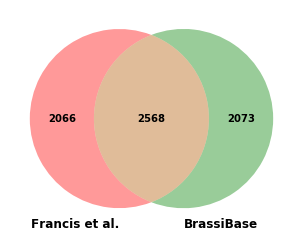

None
Synonym


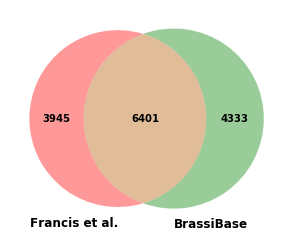

None
All
All


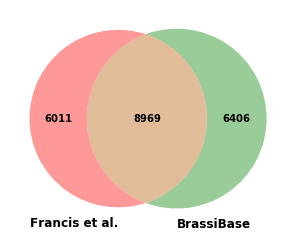

None


In [45]:
# library
#import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
 
# First way to call the 2 group Venn diagram:
# our_accepted_unique = 
# bb_accepted_unique = 
# shared_accepted = 
venn2(subsets = (summary_shared["ours_accepted"][0],
                 summary_shared["bb_accepted"][0],
                 summary_shared["shared_accepted"][0]), 
      set_labels = ('Francis et al.', 'BrassiBase'))
print("Accepted")
print(plt.show())

venn2(subsets = (summary_shared["ours_synonym"][0],
                 summary_shared["bb_synonym"][0],
                 summary_shared["shared_synonym"][0]), 
      set_labels = ('Francis et al.', 'BrassiBase'))
print("Synonym")
print(plt.show())
# Second way
#venn2([set(['A', 'B', 'C', 'D']), set(['D', 'E', 'F'])])
#plt.show()

print("All")
venn2(subsets = ((summary_shared["ours_accepted"][0] + summary_shared["ours_synonym"][0]),
                 (summary_shared["bb_accepted"][0] + summary_shared["bb_synonym"][0]),
                 (summary_shared["shared_accepted"][0] + summary_shared["shared_synonym"][0])), 
      set_labels = ('Francis et al.', 'BrassiBase'))
print("All")
print(plt.show())


Find near matches from the two...

In [50]:
import numpy as np
def levenshtein_ratio_and_distance(s, t, ratio_calc = False):
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    if ratio_calc == True:
        # Computation of the Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
        return Ratio
    else:
        # print(distance) # Uncomment if you want to see the matrix showing how the algorithm computes the cost of deletions,
        # insertions and/or substitutions
        # This is the minimum number of edits needed to convert string a to string b
        return "The strings are {} edits away".format(distance[row][col])

In [65]:
#### SET TYPE OF LIST #####
type_of_list = "synonym" #accepted or synonym
type_of_match = "exact" #exact or all
##########################

if type_of_list == "synonym":
    our_list = our_synonym_list
    bb_list = bb_synonym_list
    merged_df = pd.DataFrame (columns=["Name_F","Synonym_of","Name_IPNI","Name_BB","BB_synonym_of",
                                   "Match_F","MatchBB","Type"])
else:
    our_list = our_accepted_list
    bb_list = bb_accepted_list
    merged_df = pd.DataFrame (columns=["Name_F","Name_IPNI","Name_BB",
                                   "Match_F","MatchBB","Type"])

our_list_updated = our_list
bb_list_updated = bb_list


if type_of_match == "all":
    our_list_updated.loc[((our_list_updated.MATCH == False) &
                               (our_list_updated['SCORE']>0.9) &
                               (our_list_updated['SCORE2']>=score_threshold)),'MATCH']='Near Match'
    bb_list_updated.loc[((bb_list_updated.MATCH == False) &
                               (bb_list_updated['SCORE']>0.9) &
                               (bb_list_updated['SCORE2']>=score_threshold)),'MATCH']='Near Match'

# else: #Do nothing there will be no names tagged as Near Match




# Cleanup dataframes and make lists
our_list_updated["SCIENTIFIC_NAME"] = our_list_updated["FULL_NAME"].str.strip() + " " + our_list_updated["BAUTH"] + " " + our_list_updated["AUTH"]
bb_list_updated.loc[(bb_list_updated.MATCH == False),'MATCHED_NAME']= ""
bb_matched_list = bb_list_updated["MATCHED_NAME"].tolist()
bb_matched_list = [i for i in bb_matched_list if i] #remove empty strings
bb_names_list = bb_list_updated["Name"].tolist()
our_list_updated.SCIENTIFIC_NAME = our_list_updated.SCIENTIFIC_NAME.str.replace('  ', ' ')
our_list_updated.SCIENTIFIC_NAME = our_list_updated.SCIENTIFIC_NAME.str.strip()


for row, name in enumerate(our_list_updated["SCIENTIFIC_NAME"]):
    matched_name = our_list_updated["MATCHED_NAME"][row]
    match_type =  our_list_updated["MATCH"][row]
    synonym_of = our_list_updated["SYNONYM_OF"][row]
    #print(name)
    if our_list_updated["MATCH"][row] is True or our_list_updated["MATCH"][row] == "Near Match":
        if matched_name in bb_matched_list:
            for row_bb, bb_matched_name in enumerate(bb_list_updated["MATCHED_NAME"]):
                bb_name = bb_list_updated["Name"][row_bb]
                bb_synonym_of = bb_list_updated["Synonym.of"][row_bb]
                bb_match_type = bb_list_updated["MATCH"][row_bb]
                names_in_df = merged_df["Name_F"].tolist()
                if bb_matched_name == matched_name:
                    if name in names_in_df:
                        print("1Warning " + name + " already in df")
                    if type_of_list == "synonym":
                        merged_df = merged_df.append ({"Name_F":name,
                                                       "Synonym_of":synonym_of,
                                                       "Name_IPNI":matched_name,
                                                       "Name_BB": bb_name,
                                                       "BB_synonym_of": bb_synonym_of,
                                                       "Match_F": match_type,
                                                       "MatchBB": bb_match_type,
                                                       "Type":"ALL"}, ignore_index=True)
                    else:
                        merged_df = merged_df.append ({"Name_F":name,
                                               "Name_IPNI":matched_name,
                                               "Name_BB": bb_name,
                                               "Match_F": match_type,
                                                "MatchBB": bb_match_type,
                                                "Type":"ALL"}, ignore_index=True)
                    # = treatment_list [treatment_list["file"] == file_short]['name'].item()



        else: #IPNI yes, no match to bb match
            name_added = False
            for row_bb, bb_name in enumerate(bb_list_updated["Name"]):
                #bb_name = bb_name
                full_name = our_list_updated["FULL_NAME"][row]
                if full_name in bb_name:
                    if (" var. " in bb_name and " var. " not in full_name) or (" subsp. " in bb_name and " subsp. " not in full_name):
                        continue

                    names_in_df = merged_df["Name_F"].tolist()
                    if name in names_in_df:
                        print("2Warning " + name + " already in df")
                    bb_match_type = bb_list_updated["MATCH"][row_bb]
                    bb_synonym_of = bb_list_updated["Synonym.of"][row_bb]
                    if type_of_list == "synonym":
                        merged_df = merged_df.append ({"Name_F":name,
                                                       "Synonym_of":synonym_of,
                                                       "Name_IPNI":matched_name,
                                                       "Name_BB": bb_name,
                                                       "BB_synonym_of": bb_synonym_of,
                                                       "Match_F": match_type,
                                                       "MatchBB": bb_match_type,
                                                       "Type":"FrancisIPNI"}, ignore_index=True)
                    else:
                        merged_df = merged_df.append ({"Name_F":name,
                                                "Name_IPNI":matched_name,
                                               "Name_BB": bb_name,
                                               "Match_F": match_type,
                                                "MatchBB": bb_match_type,
                                                "Type":"FrancisIPNI"}, ignore_index=True)
                    if name == bb_name:
                        print("warning ??")
                        print(bb_name)
                    name_added = True
            if name_added is not True:
                print("Couldn't find match for " + name)
                if type_of_list == "synonym":
                    merged_df = merged_df.append ({"Name_F":name,
                                                   "Synonym_of":synonym_of,
                                                   "Name_IPNI":matched_name,
                                                   "Name_BB": bb_name,
                                                   "BB_synonym_of": bb_synonym_of,
                                                   "Match_F": match_type,
                                                   "MatchBB": bb_match_type,
                                                   "Type":"FrancisIPNI"}, ignore_index=True)
                else:
                    merged_df = merged_df.append ({"Name_F":name,
                                           "Name_IPNI":matched_name,
                                           "Name_BB": bb_name,
                                           "Match_F": match_type,
                                            "MatchBB": bb_match_type,
                                            "Type":"FrancisIPNI"}, ignore_index=True)



                    #print("")
    elif name in bb_names_list:  #no match on ipni
        name_added = False
        for row_bb, bb_name in enumerate(bb_list_updated["Name"]):
            if name == bb_name:
                names_in_df = merged_df["Name_F"].tolist()
                if name in names_in_df:
                    print("3Warning " + name + " already in df")
                bb_match_type = bb_list_updated["MATCH"][row_bb]
                bb_synonym_of = bb_list_updated["Synonym.of"][row_bb]
                if type_of_list == "synonym":
                    merged_df = merged_df.append ({"Name_F":name,
                                                   "Synonym_of":synonym_of,
                                                   "Name_IPNI":matched_name,
                                                   "Name_BB": bb_name,
                                                   "BB_synonym_of": bb_synonym_of,
                                                   "Match_F": match_type,
                                                   "MatchBB": bb_match_type,
                                                   "Type":"FrancisBB"}, ignore_index=True)
                else:
                    merged_df = merged_df.append ({"Name_F":name,
                                           "Name_IPNI":matched_name,
                                           "Name_BB": bb_name,
                                           "Match_F": match_type,
                                            "MatchBB": bb_match_type,
                                            "Type":"FrancisBB"}, ignore_index=True)
                name_added = True
        if name_added is not True:
#             if type_of_list == "synonym":
#                 merged_df = merged_df.append ({"Name_F":name,
#                                                "Synonym_of":synonym_of,
#                                                "Name_IPNI":matched_name,
#                                                "Name_BB": bb_name,
#                                                "BB_synonym_of": bb_synonym_of,
#                                                "Match_F": match_type,
#                                                "MatchBB": bb_match_type,
#                                                "Type":"Francis"}, ignore_index=True)
#             else:
#                 merged_df = merged_df.append ({"Name_F":name,
#                                        "Name_IPNI":matched_name,
#                                        "Name_BB": bb_name,
#                                        "Match_F": match_type,
#                                         "MatchBB": bb_match_type,
#                                         "Type":"Francis"}, ignore_index=True)
            print("2Couldn't find match " + name)
        #continue
    else:
        name_added = False
        for row_bb, bb_name in enumerate(bb_list_updated["Name"]):
            full_name = our_list_updated["FULL_NAME"][row]
            if full_name in bb_name:
                if (" var. " in bb_name and " var. " not in full_name) or (" subsp. " in bb_name and " subsp. " not in full_name):
                    continue
                names_in_df = merged_df["Name_F"].tolist()
                if name in names_in_df:
                    print("4Warning " + name + " already in df")
                bb_match_type = bb_list_updated["MATCH"][row_bb]
                bb_synonym_of = bb_list_updated["Synonym.of"][row_bb]
                if type_of_list == "synonym":
                    merged_df = merged_df.append ({"Name_F":name,
                                                   "Synonym_of":synonym_of,
                                                   "Name_IPNI":matched_name,
                                                   "Name_BB": bb_name,
                                                   "BB_synonym_of": bb_synonym_of,
                                                   "Match_F": match_type,
                                                   "MatchBB": bb_match_type,
                                                   "Type":"Francis"}, ignore_index=True)
                else:
                    merged_df = merged_df.append ({"Name_F":name,
                                           "Name_IPNI":matched_name,
                                           "Name_BB": bb_name,
                                           "Match_F": match_type,
                                            "MatchBB": bb_match_type,
                                            "Type":"Francis"}, ignore_index=True)
                name_added = True
        if name_added is not True:
            if type_of_list == "synonym":
                merged_df = merged_df.append ({"Name_F":name,
                                               "Synonym_of":synonym_of,
                                               "Name_IPNI":matched_name,
                                               "Name_BB": bb_name,
                                               "BB_synonym_of": bb_synonym_of,
                                               "Match_F": match_type,
                                               "MatchBB": bb_match_type,
                                               "Type":"Francis"}, ignore_index=True)
            else:
                merged_df = merged_df.append ({"Name_F":name,
                                       "Name_IPNI":matched_name,
                                       "Name_BB": bb_name,
                                       "Match_F": match_type,
                                        "MatchBB": bb_match_type,
                                        "Type":"Francis"}, ignore_index=True)
            print("3Couldn't find match " + name)

merged_df.loc[((merged_df.Type == "Francis") &  (merged_df.MatchBB == "True")),'Type']='BBIPNI'
merged_df.loc[((merged_df.Type == "Francis") &  (merged_df.MatchBB == "Near Match" )),'Type']='BBIPNI'

for row, bb_name in enumerate(bb_list_updated.Name):
    names_in_df = merged_df["Name_BB"].tolist()
    if bb_name not in names_in_df:
        matched_name = bb_list_updated["MATCHED_NAME"][row]
        bb_match_type =  bb_list_updated["MATCH"][row]
        bb_synonym_of = bb_list_updated["Synonym.of"][row_bb]
        if type_of_list == "synonym":
            merged_df = merged_df.append ({"Name_F":"",
                                           "Synonym_of":synonym_of,
                                           "Name_IPNI":matched_name,
                                           "Name_BB": bb_name,
                                           "BB_synonym_of": bb_synonym_of,
                                           "Match_F": "",
                                           "MatchBB": bb_match_type,
                                           "Type":"BB"}, ignore_index=True)
        else:
            merged_df = merged_df.append ({"Name_F":"",
                                   "Name_IPNI":matched_name,
                                   "Name_BB": bb_name,
                                   "Match_F": "",
                                    "MatchBB": bb_match_type,
                                    "Type":"BB"}, ignore_index=True)

merged_df.loc[((merged_df.Type == "BB") &  (merged_df.MatchBB == "True")),'Type']='BBIPNI'
merged_df.loc[((merged_df.Type == "BB") &  (merged_df.MatchBB == "Near Match" )),'Type']='BBIPNI'
merged_df.to_csv('/home/lujantorob/global_brassicaceae_checklist_v2/data/interim/merged_data_' +
                 type_of_list + "_" + type_of_match + '.csv', index=False, encoding='utf-8')

#IF name
#AT THE end check for BB names not added yet.

Couldn't find match for Achoriphragma saxifragum (Botsch. & Vved.) Soják
Couldn't find match for Acuston lunarioides (Willd.) Raf.
3Couldn't find match Aethionema chloraefolium (Sibth. & Sm.) Boiss.
Couldn't find match for Aethionema edentulum N.Busch
Couldn't find match for Aethionema grandiflorum var. sintenisii (Hausskn. & Bornm.) Govaerts
Couldn't find match for Aethionema levandowskyi N.Busch
3Couldn't find match Aethionema monospermum subsp. monospermum W.T.Aiton
Couldn't find match for Aethionema schelkownikowii Bordz.
3Couldn't find match Aethionema sintenisii Hausskn. & Bornm. ex Bornm.
Couldn't find match for Aethionema spinosum (Boiss.) N.Busch
Couldn't find match for Aethionema virgatum var. stenopterum (Boiss.) Govaerts
3Couldn't find match Aethionema woronovii Schischk.
3Couldn't find match Alyssum alpestre prol. jordani Rouy & Foucaud
4Warning Alyssum alpestre subsp. serpyllifolium (Desf.) Rouy & Foucaud already in df
3Couldn't find match Alyssum alpestre var. macrocarpu

3Couldn't find match Arabis lemmonii var. lemmonii S.Watson
3Couldn't find match Arabis lyallii var. lyallii S.Watson
3Couldn't find match Arabis lyrata var. lyrata L.
3Couldn't find match Arabis microphylla var. microphylla Nutt.
Couldn't find match for Arabis montbretiana Boiss.
Couldn't find match for Arabis mrkvickana Velen.
3Couldn't find match Arabis muralis subsp. collina var. rosea (DC.) Thell.
3Couldn't find match Arabis nemorensis (Wolf ex Hoffm.) Wolf ex W.D.J.Koch
Couldn't find match for Arabis paniculata var. parviflora (Franch.) W.T.Wang
3Couldn't find match Arabis pendula var. glabrescens Franch.
3Couldn't find match Arabis pendula var. hypoglauca Franch.
3Couldn't find match Arabis pendulina var. pendulina Greene
Couldn't find match for Arabis pendulocarpa var. saximontana (Rollins) Dorn
3Couldn't find match Arabis platysperma var. platysperma A.Gray
3Couldn't find match Arabis pulchra var. pulchra M.E.Jones ex S.Watson
3Couldn't find match Arabis pumila subsp. pumila J

Couldn't find match for Braya humilis subsp. richardsonii (Rydb.) Hultén
Couldn't find match for Braya humilis var. leiocarpa (Trautv.) Fernald
3Couldn't find match Braya lapeyrousiana (Rouy & Foucaud) Bonnier
3Couldn't find match Braya marinelli Pamp.
3Couldn't find match Braya oxycarpa var. stenocarpa O.E.Schultz
Couldn't find match for Braya purpurascens subsp. pilosa (Hook.) Hultén
Couldn't find match for Braya purpurascens var. fernaldii (Abbe) B.Boivin
3Couldn't find match Braya purpurascens var. longisiliquosa Traut.
3Couldn't find match Braya rosea var. leiocarpa O.E.Schulz
3Couldn't find match Braya sternbergii Krasn.
3Couldn't find match Braya thomsonii var. pamirica (Korsh.) O.E.Schulz
3Couldn't find match Braya thorild-wulffii subsp. thorild-wulffii Ostenf.
3Couldn't find match Brossardia papyracea var. kotschyi Boiss.
3Couldn't find match Cakile aegyptia var. australis (Coss. ex Loret & Barrandon) Maire & Weiller
3Couldn't find match Cakile aegyptia var. edentula (Jord.) M

3Couldn't find match Crambe vieraena Webb ex H. Christ
Couldn't find match for Cymatocarpus heterophyllus (Popov) N.Busch
Couldn't find match for Dentaria tenella Pursh
4Warning Descurainia brachycarpa (Richardson) O.E.Schulz already in df
4Warning Descurainia brachycarpa (Phil.) Prantl ex Reiche already in df
Couldn't find match for Descurainia brevifructa Boelcke ex Mart.-Laborde
3Couldn't find match Descurainia canescens var. appendiculatum (Griseb.) Hosseus
3Couldn't find match Descurainia canescens var. pimpinellifolium (Barn.) Reiche
Couldn't find match for Descurainia macrorrhiza Muschl. ex O.E.Schulz
Couldn't find match for Descurainia minutiflora var. florida (Phil.) Reiche
3Couldn't find match Descurainia myriophylla var. latisiliqua Muschl. ex O.E.Schulz
3Couldn't find match Descurainia obtusa subsp. typica (Greene) O.E.Schulz
3Couldn't find match Dileptium praecox Raf.
3Couldn't find match Diplotaxis acris var. griffithii (Hook.f. & Thomson) Coss.
3Couldn't find match Diplo

3Couldn't find match Erucastrum thellungii var. incrassatum Thell.
3Couldn't find match Erucastrum virgatum subsp. baeticum var. lucentinum Gómez-Campo
Couldn't find match for Erysimum absconditum O.E.Schulz
Couldn't find match for Erysimum afghanicum Kitam.
3Couldn't find match Erysimum altaicum subsp. shinganicum Y.L.Chang
3Couldn't find match Erysimum altaicum var. baicalense M.Pop.
3Couldn't find match Erysimum andrzejowskianum Besser
4Warning Erysimum aurantiacum (F.E.Leyb.) F.E.Leyb. already in df
Couldn't find match for Erysimum aurigeranum Jeanb. & Timb.-Lagr.
3Couldn't find match Erysimum benthamii var. grandiflorum P.Monnet
2Warning Erysimum bracteatum W.W.Sm. already in df
3Couldn't find match Erysimum cheiranthoides var. sinuatum Franch.
2Warning Erysimum cinereum Wettst. already in df
Couldn't find match for Erysimum eginense Hausskn. ex Bornm.
Couldn't find match for Erysimum etnense Jord.
2Warning Erysimum filifolium F.Muell. already in df
Couldn't find match for Erysimu

3Couldn't find match Ihsanalshehbazia granatensis (Boiss. & Reut.) Tahir Ali & Thines
3Couldn't find match Ionopsidium prolongoi subsp. heterospermum (Batt.) Heywood
3Couldn't find match Isatis apennina Ten.
3Couldn't find match Isatis cappadocica subsp. subradiata var. gudrunensis (Boiss.) P.H.Davis
3Couldn't find match Isatis cappadocica subsp. subradiata var. subradiata (Rupr.) P.H.Davis
Couldn't find match for Isatis collina Boiss.
Couldn't find match for Isatis oblongata DC.
Couldn't find match for Isatis praecox Kit. ex Tratt.
Couldn't find match for Isatis reticulata C.A.Mey.
Couldn't find match for Kotschyella cilicica (Schott & Kotschy ex Boiss.) F.K.Mey.
Couldn't find match for Kotschyella stenocarpa (Boiss.) F.K.Mey.
3Couldn't find match Lepidium aethiopicum Welw. ex Hiern
2Warning Lepidium ambiguum F.Muell. already in df
3Couldn't find match Lepidium argenteum var. stenocarpum (Thell.) Thell.
3Couldn't find match Lepidium aucheri var. borsczovii Regel
Couldn't find match fo

3Couldn't find match Moricandia arvensis subsp. arvensis var. garamantum (Maire) Maire
3Couldn't find match Moricandia teretifolia f. genuina Batt.
Couldn't find match for Mostacillastrum elongatum var. latisiliquum O.E.Schulz
3Couldn't find match Murbeckiella pinnatifida subsp. pinnatifida Rothm.
3Couldn't find match Myagrum erucaefolium Vill.
3Couldn't find match Napus leucosinapis K.F.Schimp. & Spenn.
Couldn't find match for Nasturtiopsis coronopifolia subsp. arabica (Boiss.) Greuter & Burdet
3Couldn't find match Nasturtiopsis coronopifolia subsp. coronopifolia Boiss.
3Couldn't find match Nasturtium afghanicum (Boiss.) Kuntze
4Warning Nasturtium armoracia (Fisch. & C.A.Mey.) Kuntze already in df
4Warning Nasturtium dictyotum (A.Gray) Kuntze already in df
3Couldn't find match Nasturtium erinaceum (Boiss.) Kuntze
4Warning Nasturtium fluviatile E.Mey. ex Sond. already in df
2Warning Nasturtium heterophyllum D.Don already in df
3Couldn't find match Nasturtium noëanum Boiss.
2Warning Nas

Couldn't find match for Sibara matthioloides (Schltdl.) Al-Shehbaz
3Couldn't find match Sinalliaria limprichtiana var. grandifolia (Z.H.An) X.F.Jin, Y.Y.Zhou & H.W.Zhang
Couldn't find match for Sinapis brassicata L.
Couldn't find match for Sinapis sicula Bertol.
3Couldn't find match Sinapis ucrainica Czern. ex Turcz.
2Warning Sinapis virgata C.Presl already in df
2Warning Sisymbrium adpressum Turcz. already in df
3Couldn't find match Sisymbrium alpinum var. aeneum (Bunge) Trautv.
Couldn't find match for Sisymbrium alpinum var. glabellum (Richardson) Trautv.
3Couldn't find match Sisymbrium alpinum var. roseum (Bunge) Trautv.
2Warning Sisymbrium amplexicaule A.Gray already in df
2Warning Sisymbrium amplexicaule A.Gray already in df
Couldn't find match for Sisymbrium amplexicaule var. tenuicaule O.E.Schulz
3Couldn't find match Sisymbrium andinum var. exauriculatum (Speg.) O.E.Schulz
3Couldn't find match Sisymbrium andinum var. junclense O.E.Schulz
Couldn't find match for Sisymbrium arnott

Couldn't find match for Thlaspiceras dolichocarpum (Zohary) F.K.Mey.
Couldn't find match for Thlaspiceras eigii (Zohary) F.K.Mey.
Couldn't find match for Thlaspiceras elegans (Boiss.) F.K.Mey.
Couldn't find match for Thlaspiceras huber-morathii F.K.Mey.
Couldn't find match for Thlaspiceras oxyceras (Boiss.) F.K.Mey.
Couldn't find match for Thlaspiceras rechingeri F.K.Mey.
Couldn't find match for Thlaspiceras triangulare F.K.Mey.
3Couldn't find match Tomostina caroliniana (Walter) Raf.
3Couldn't find match Tomostina hispidula (Michx.) Raf.
4Warning Torularia humilis (C.A.Mey.) O.E.Schulz already in df
3Couldn't find match Torularia humilis prol. piasezkii (Maxim.) O.E.Schulz
3Couldn't find match Torularia humilis var. piasezkii (Maxim.) Jafri
3Couldn't find match Turritis drummondii var. brachycarpa (Torr. & A.Gray) Lunell
Couldn't find match for Turritis ovata Pursh
Couldn't find match for Turritis salsuginosa DC.
Couldn't find match for Vania campylophylla F.K.Mey.
Couldn't find match

In [36]:
print(len(our_accepted_list))
print(len(our_synonym_list))
merged = pd.read_csv('/home/lujantorob/global_brassicaceae_checklist_v2/data/interim/merged_data_accepted_exact.csv').fillna("")
merged_synonym = pd.read_csv('/home/lujantorob/global_brassicaceae_checklist_v2/data/interim/merged_data_synonym_exact.csv').fillna("")

name_list = merged["Name_F"].tolist()
name_list2 = merged_synonym["Name_F"].tolist()

print("Accepted")
for name in our_accepted_list["SCIENTIFIC_NAME"]:
    if name not in name_list:
        print("Missing " + name)

seen = {}
dupes = []

for x in merged.Name_F:
    if x not in seen:
        seen[x] = 1
    else:
        if seen[x] == 1:
            dupes.append(x)
        seen[x] += 1
print(dupes)
        
        
print("Synonym")
for name in our_accepted_list["SCIENTIFIC_NAME"]:
    if name not in name_list:
        print("Missing " + name)
seen = {}
dupes = []

for x in merged_synonym.Name_F:
    if x not in seen:
        seen[x] = 1
    else:
        if seen[x] == 1:
            dupes.append(x)
        seen[x] += 1
print(len(dupes))
print(dupes)

4634
10346
Accepted
['Boechera fernaldiana (Rollins) W.A.Weber', '']
Synonym
130
['Alyssum alpestre subsp. serpyllifolium (Desf.) Rouy & Foucaud', 'Alyssum densiflorum (A.Gray) Kuntze', 'Alyssum micropetalum Fisch.', 'Alyssum orbiculare Jeanb. & Timb.', 'Alyssum suffrutescens Hal\xc3\xa1csy', 'Anchonium elichrysifolium subvar. cilicicum Siehe ex Bornm.', 'Arabidopsis tibetica (Hook.f. & Thomson) Y.C.Lan & Z.X.An ex K.C.Kuan', 'Arabidopsis tibetica (Hook.f. & Thomson) Naqshi & Javeid', 'Arabis albida Steven ex Fisch.', 'Arabis arcuata Shuttlew.', 'Arabis arcuata (Nutt.) A.Gray', 'Arabis bellidifolia Crantz', 'Arabis elegans A.Nelson', 'Arabis fauriei H.Boissieu', 'Arabis fauriei H.L\xc3\xa9v.', 'Arabis inamoena Greene', 'Arabis purpurascens T.J.Howell ex Greene', 'Arabis runcinata S.Watson', 'Arabis secunda T.J.Howell', 'Arabis secunda N.Busch', 'Biscutella laevigata subsp. longifolia (Vill.) Rouy & Foucaud', 'Biscutella valentina subsp. valentina (L.) Heywood', 'Brassica amplexicaulis 

### Including near matches, with whitespace

Accepted
3045
251
498
326
4120

Synonym
6080
539
1865
1080
9564


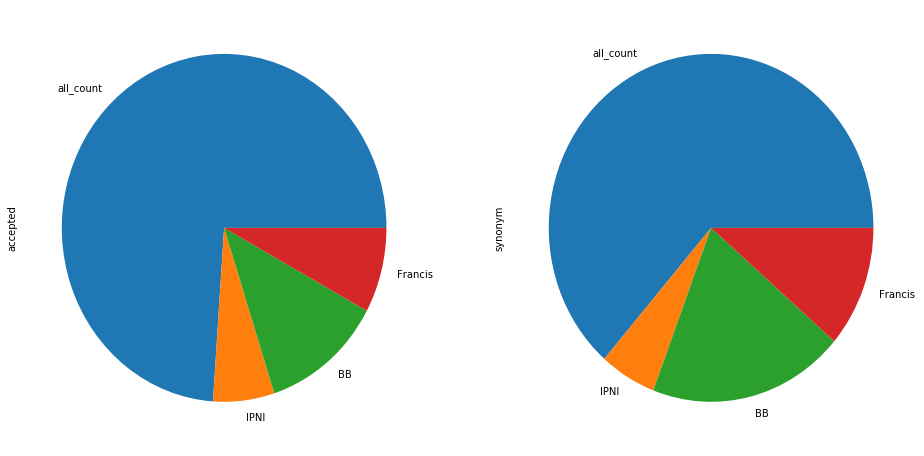

In [22]:
merged = pd.read_csv('/home/lujantorob/global_brassicaceae_checklist_v2/data/interim/merged_data_accepted_all.csv').fillna("")
merged_synonym = pd.read_csv('/home/lujantorob/global_brassicaceae_checklist_v2/data/interim/merged_data_synonym_all.csv').fillna("")

#['FrancisIPNI', 'FrancisBB', 'ALL', 'Francis']

all_count = len(merged[merged['Type']=="ALL"])
francis_ipni = len(merged[merged['Type']=="FrancisIPNI"])
francis_bb = len(merged[merged['Type']=="FrancisBB"])
francis = len(merged[merged['Type']=="Francis"])
accepted_chart = [all_count, francis_ipni, francis_bb, francis]

all_count_synonym = len(merged_synonym[merged_synonym['Type']=="ALL"])
francis_ipni_synonym = len(merged_synonym[merged_synonym['Type']=="FrancisIPNI"])
francis_bb_synonym = len(merged_synonym[merged_synonym['Type']=="FrancisBB"])
francis_synonym = len(merged_synonym[merged_synonym['Type']=="Francis"])
synonym_chart = [all_count_synonym, francis_ipni_synonym, francis_bb_synonym, francis_synonym]

all_sum = 0
print("Accepted")
for item in accepted_chart:
    all_sum = all_sum + item
    print(item)
print(all_sum)
print
all_sum = 0
print("Synonym")
for item in synonym_chart:
    all_sum = all_sum + item
    print(item)
print(all_sum)
    
# --- dataset 1: just 4 values for 4 groups:
#df = pd.DataFrame(accepted_chart, index=['all_count', 'IPNI', 'BB', 'Francis'], columns=['x'])
df = pd.DataFrame({'accepted':accepted_chart, 'synonym':synonym_chart}, index=['all_count', 'IPNI', 'BB', 'Francis'])

#df = pd.DataFrame({'var1':[8,3,4,2], 'var2':[1,3,4,1]}, index=['a', 'b', 'c', 'd'] )

 
# make the plot
#print(df.plot(kind='pie', subplots=True, figsize=(8, 8)))
print(df.plot(kind='pie', subplots=True, figsize=(16,8), legend=None))

In [23]:
#To include the differences with whitespace
from collections import Counter

merged = pd.read_csv('/home/lujantorob/global_brassicaceae_checklist_v2/data/interim/merged_data_accepted_all.csv').fillna("")

count=0
type_list = []
for row, bb_name in enumerate(merged.Name_BB):
    our_name = merged.Name_F[row].replace(" ", "")
    bb_name = bb_name.replace(" ", "")
    if bb_name == our_name:
        type_list.append(merged.Type[row])
        count += 1
        

print(count)
#print(type_list)
print(Counter(type_list).keys())
print(Counter(type_list).values())

merged_synonym = pd.read_csv('/home/lujantorob/global_brassicaceae_checklist_v2/data/interim/merged_data_synonym_all.csv').fillna("")

count=0
type_list = []
for row, bb_name in enumerate(merged_synonym.Name_BB):
    our_name = merged_synonym.Name_F[row].replace(" ", "")
    bb_name = bb_name.replace(" ", "")
    if bb_name == our_name:
        type_list.append(merged_synonym.Type[row])
        count += 1
        

print(count)
#print(type_list)
print(Counter(type_list).keys())
print(Counter(type_list).values())

3782
['FrancisIPNI', 'FrancisBB', 'ALL', 'Francis']
[123, 498, 2940, 221]
8822
['FrancisBB', 'ALL', 'FrancisIPNI', 'Francis', 'BBIPNI']
[1865, 5946, 307, 703, 1]


### Including near matches, without whitespace

Accepted
3168
128
719
105

Synonym
7945
539
1866
1080


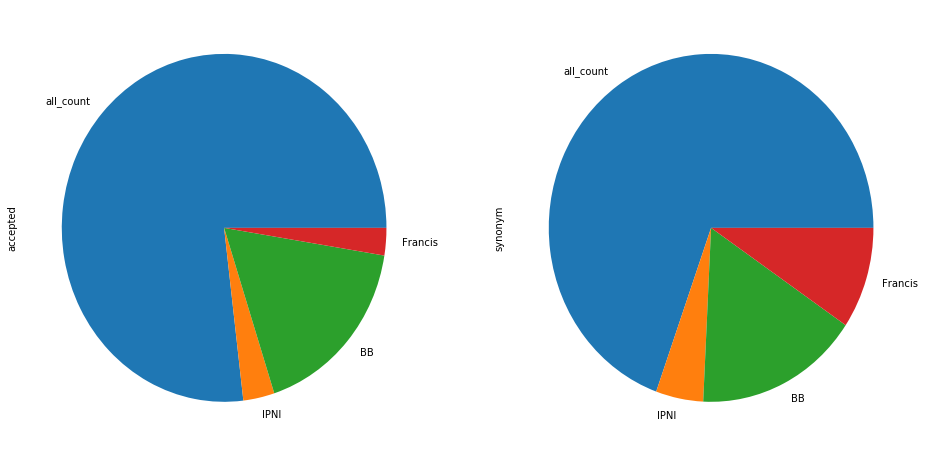

In [24]:
# ['FrancisIPNI', 'FrancisBB', 'ALL', 'Francis']
# [123, 498, 2940, 221]

all_count = len(merged[merged['Type']=="ALL"]) + 123
francis_ipni = len(merged[merged['Type']=="FrancisIPNI"]) -123
francis_bb = len(merged[merged['Type']=="FrancisBB"]) + 221
francis = len(merged[merged['Type']=="Francis"]) -221
accepted_chart = [all_count, francis_ipni, francis_bb, francis]

all_count_synonym = len(merged_synonym[merged_synonym['Type']=="ALL"]) + 1865
francis_ipni_synonym = len(merged_synonym[merged_synonym['Type']=="FrancisIPNI"])
francis_bb_synonym = len(merged_synonym[merged_synonym['Type']=="FrancisBB"]) + 1
francis_synonym = len(merged_synonym[merged_synonym['Type']=="Francis"])
synonym_chart = [all_count_synonym, francis_ipni_synonym, francis_bb_synonym, francis_synonym]

print("Accepted")
for item in accepted_chart:
    print(item)
print
print("Synonym")
for item in synonym_chart:
    print(item)

df = pd.DataFrame({'accepted':accepted_chart, 'synonym':synonym_chart}, index=['all_count', 'IPNI', 'BB', 'Francis'])

print(df.plot(kind='pie', subplots=True, figsize=(16,8), legend=None))

### Exact matches only 

Accepted
1992
1297
576
770
4635

Synonym
4296
2068
2113
2022
10499


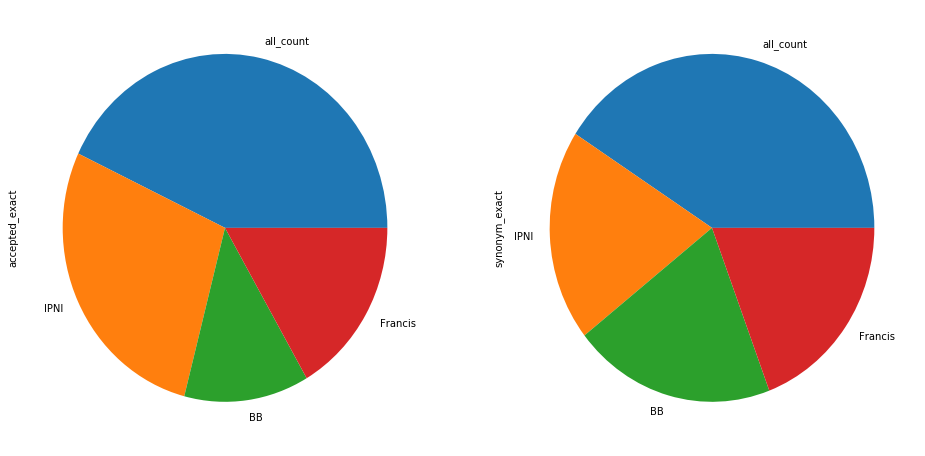

In [26]:
merged = pd.read_csv('/home/lujantorob/global_brassicaceae_checklist_v2/data/interim/merged_data_accepted_exact.csv').fillna("")
merged_synonym = pd.read_csv('/home/lujantorob/global_brassicaceae_checklist_v2/data/interim/merged_data_synonym_exact.csv').fillna("")

#['FrancisIPNI', 'FrancisBB', 'ALL', 'Francis']

all_count = len(merged[merged['Type']=="ALL"])
francis_ipni = len(merged[merged['Type']=="FrancisIPNI"])
francis_bb = len(merged[merged['Type']=="FrancisBB"])
francis = len(merged[merged['Type']=="Francis"])
accepted_chart = [all_count, francis_ipni, francis_bb, francis]

all_count_synonym = len(merged_synonym[merged_synonym['Type']=="ALL"])
francis_ipni_synonym = len(merged_synonym[merged_synonym['Type']=="FrancisIPNI"])
francis_bb_synonym = len(merged_synonym[merged_synonym['Type']=="FrancisBB"])
francis_synonym = len(merged_synonym[merged_synonym['Type']=="Francis"])
synonym_chart = [all_count_synonym, francis_ipni_synonym, francis_bb_synonym, francis_synonym]

all_sum = 0
print("Accepted")
for item in accepted_chart:
    all_sum = all_sum + item
    print(item)
print(all_sum)
print
all_sum = 0
print("Synonym")
for item in synonym_chart:
    all_sum = all_sum + item
    print(item)
print(all_sum)
    
# --- dataset 1: just 4 values for 4 groups:
df = pd.DataFrame({'accepted_exact':accepted_chart, 'synonym_exact':synonym_chart}, index=['all_count', 'IPNI', 'BB', 'Francis'])
 
# make the plot
print(df.plot(kind='pie', subplots=True, figsize=(16,8), legend=None))

### Exact matches only without whitespace 

In [28]:
#To include the differences with whitespace
from collections import Counter

merged = pd.read_csv('/home/lujantorob/global_brassicaceae_checklist_v2/data/interim/merged_data_accepted_exact.csv').fillna("")

count=0
type_list = []
for row, bb_name in enumerate(merged.Name_BB):
    our_name = merged.Name_F[row].replace(" ", "")
    bb_name = bb_name.replace(" ", "")
    if bb_name == our_name:
        type_list.append(merged.Type[row])
        count += 1
        

print(count)
#print(type_list)
print(Counter(type_list).keys())
print(Counter(type_list).values())

merged_synonym = pd.read_csv('/home/lujantorob/global_brassicaceae_checklist_v2/data/interim/merged_data_synonym_exact.csv').fillna("")

count=0
type_list = []
for row, bb_name in enumerate(merged_synonym.Name_BB):
    our_name = merged_synonym.Name_F[row].replace(" ", "")
    bb_name = bb_name.replace(" ", "")
    if bb_name == our_name:
        type_list.append(merged_synonym.Type[row])
        count += 1
        

print(count)
#print(type_list)
print(Counter(type_list).keys())
print(Counter(type_list).values())

3782
['FrancisIPNI', 'FrancisBB', 'ALL', 'Francis']
[897, 576, 1988, 321]
8823
['FrancisBB', 'ALL', 'FrancisIPNI', 'Francis']
[2113, 4296, 1531, 883]


Accepted
2889
400
897
449
4635

Synonym
6409
2068
2996
2022
13495


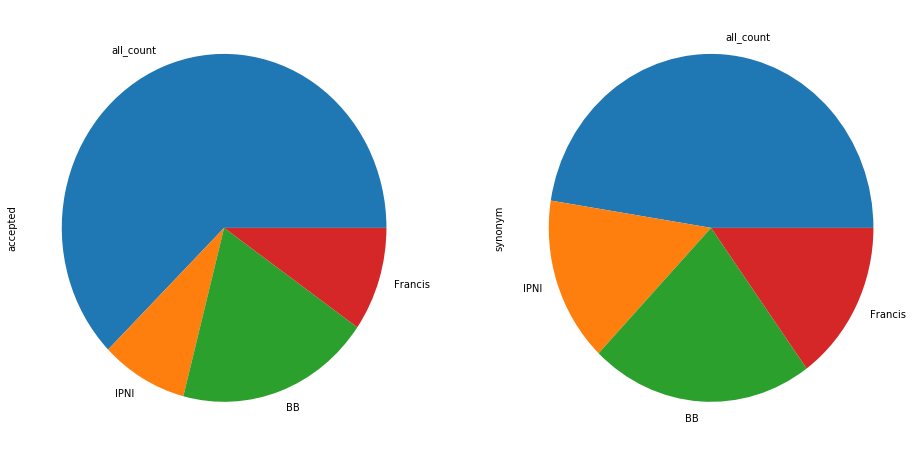

In [30]:
# ['FrancisIPNI', 'FrancisBB', 'ALL', 'Francis']

all_count = len(merged[merged['Type']=="ALL"]) + 897
francis_ipni = len(merged[merged['Type']=="FrancisIPNI"]) - 897
francis_bb = len(merged[merged['Type']=="FrancisBB"]) + 321
francis = len(merged[merged['Type']=="Francis"]) -321
accepted_chart = [all_count, francis_ipni, francis_bb, francis]

all_count_synonym = len(merged_synonym[merged_synonym['Type']=="ALL"]) + 2113
francis_ipni_synonym = len(merged_synonym[merged_synonym['Type']=="FrancisIPNI"])
francis_bb_synonym = len(merged_synonym[merged_synonym['Type']=="FrancisBB"]) + 883
francis_synonym = len(merged_synonym[merged_synonym['Type']=="Francis"])
synonym_chart = [all_count_synonym, francis_ipni_synonym, francis_bb_synonym, francis_synonym]

all_sum = 0
print("Accepted")
for item in accepted_chart:
    all_sum = all_sum + item
    print(item)
print(all_sum)
print
all_sum = 0
print("Synonym")
for item in synonym_chart:
    all_sum = all_sum + item
    print(item)
print(all_sum)

df = pd.DataFrame({'accepted':accepted_chart, 'synonym':synonym_chart}, index=['all_count', 'IPNI', 'BB', 'Francis'])

print(df.plot(kind='pie', subplots=True, figsize=(16,8), legend=None))

In [63]:
def bestMatch(matchDicc, mergedName):
    ratio = 0
    row = ""
    for bb_merged_name in matchDicc:
        new_ratio = levenshtein_ratio_and_distance(bb_merged_name,mergedName,ratio_calc = True)
        if new_ratio > ratio:
            row = matchDicc[bb_merged_name]
            ratio = new_ratio
    return row
name = "Alyssum afghanicum Rech.f.Alyssum turkestanicum"
new_dicc = {}
new_dicc["Alyssum afghanicum Rech..Alyssum turkestanicum"] = 3
new_dicc["Alyssum afghanicum Rech.f .Alyssum turkestanicum"] = 4

print(bestMatch(new_dicc,name))

4
